# Plotting epi parameter estimates from bayesian logistic growth model (R)

### Setup

In [1218]:
library(ggplot2)
library(tidyverse)
library(RColorBrewer)
library(magrittr)
library(lubridate)
library(scales)
library(patchwork)

In [1219]:
my_theme <- function() {
    theme_classic() +
    theme( 
        plot.title = element_text(color="black", size=12, face="bold"),
        axis.title.x = element_text(color="black", size=16, face="bold", vjust=-1),
        axis.title.y = element_text(color="black", size=16, face="bold", vjust=2),
        axis.text=element_text(size=18))
}

options(repr.plot.width=14, repr.plot.height=8)

In [1013]:
# early outbreak dates 
eod <- as.Date(c('2022-05-01', '2022-08-01'))

# tmrca estimates from BEAST
tmrca <- ymd('2021-12-20')
tmrca_upper <- ymd('2022-02-05')
tmrca_lower <- ymd('2021-10-22')

# Posterior distribution of netau under logistic growth model 

### Read in logistic model output

In [3]:
path <- '../out/logistic/'
#'/Users/nashwa/Desktop/git/hmpxv_dynamics/out/logistic/'
netau <- read.table(paste0(path,'logistic_growth_t50.tsv'), sep='\t', header=T)
head(netau)

,time,date,datetime,milliseconds,mean,median,upper,lower
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2022.797,2022-10-18,2022-10-18T08:00:00,1.666080e+12,25.31316,20.31142,49.88838,11.43242
2,2022.790,2022-10-15,2022-10-15T18:05:03,1.665857e+12,24.82678,20.29794,49.80448,11.43185
3,2022.783,2022-10-13,2022-10-13T04:10:06,1.665634e+12,24.45672,20.27839,49.49118,11.43120
4,2022.776,2022-10-10,2022-10-10T14:15:09,1.665411e+12,24.15676,20.24913,49.10957,11.43046
5,2022.769,2022-10-08,2022-10-08T00:20:12,1.665188e+12,23.90278,20.22491,48.70991,11.42962
6,2022.762,2022-10-05,2022-10-05T10:25:15,1.664966e+12,23.68077,20.21632,48.39194,11.42868


In [53]:
# format date 
netau <- netau %>% mutate(month = months(as.Date(datetime)))
netau <- netau %>% mutate(datetime = as_date(date))

## Netau through time

### Netau through time (log scale) 

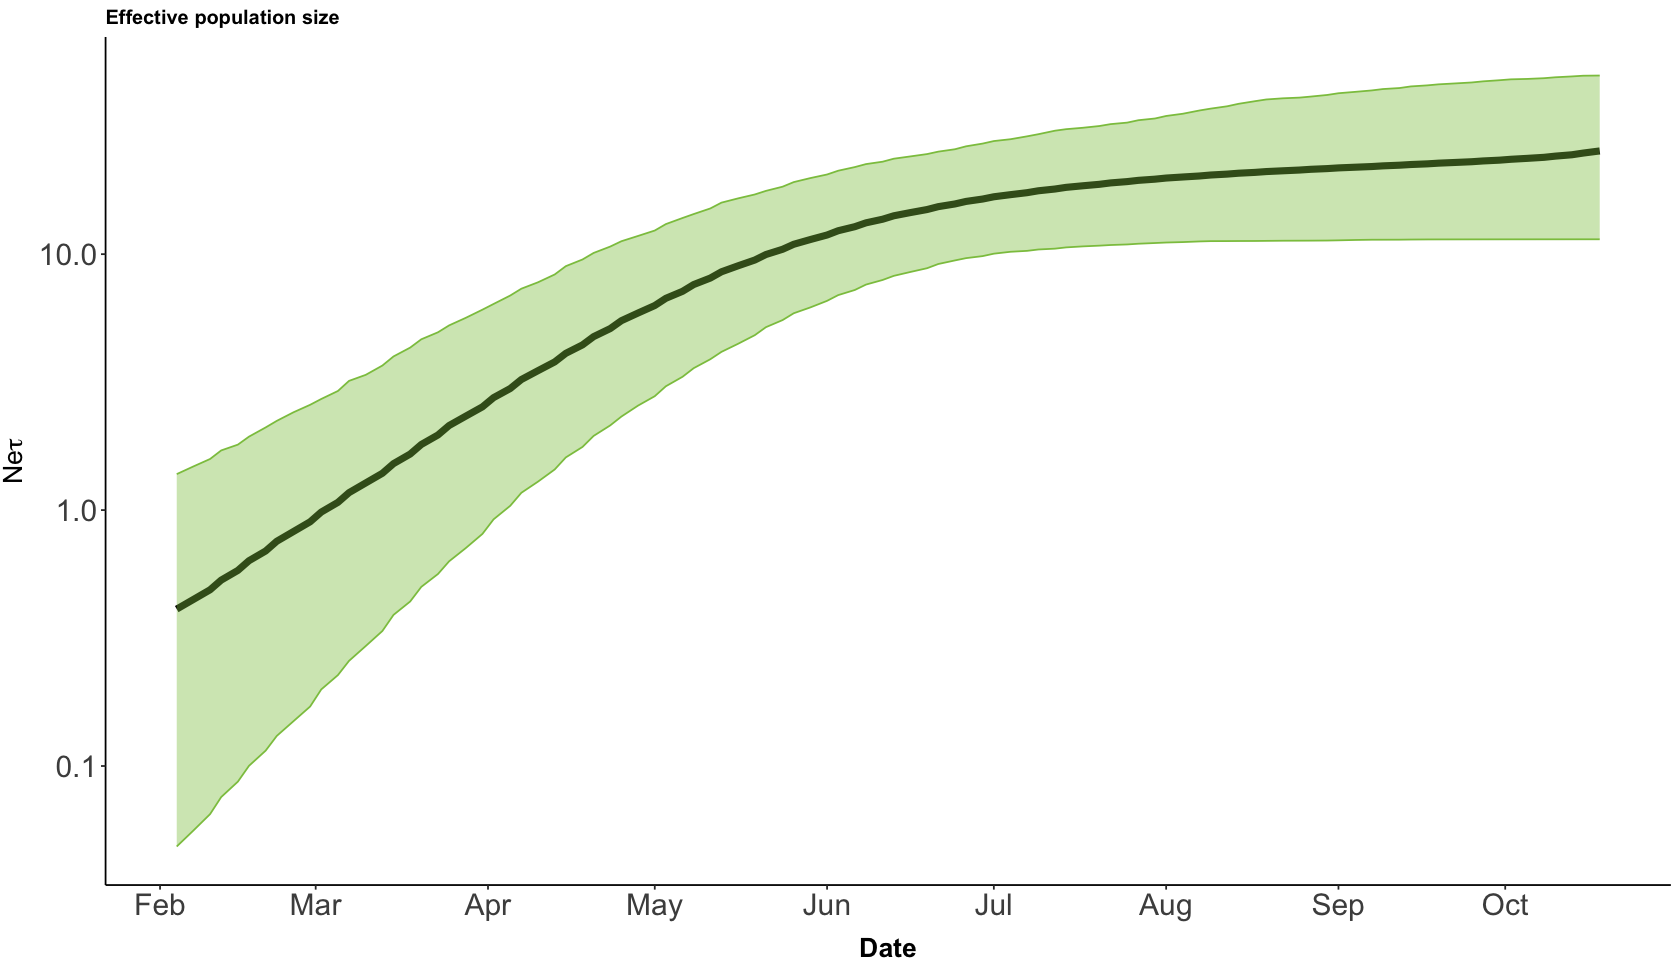

In [1537]:
plot_log_scale_netau <- netau %>% mutate(ne = mean, 
                 ne_lower = lower,
                 ne_upper = upper) %>% 
          ggplot(aes(x=datetime, y=ne)) +
          geom_line(size=2, color='black') +
          geom_ribbon(aes(ymin=ne_lower, ymax=ne_upper), color=rgb(0.55,0.77,0.3), alpha=0.4, fill=rgb(0.55,0.77,0.3)) +
          ylab(bquote(Ne*tau)) + xlab('Date') + ggtitle('Effective population size') + 
          scale_x_date(date_labels = "%b", date_breaks='months') +
          scale_y_continuous(trans='log10') +
          my_theme()

plot_log_scale_netau 

#ggsave('netau_gg.png', width=14, height=8)

## Ne<sub>τ</sub> with TMRCA overlay

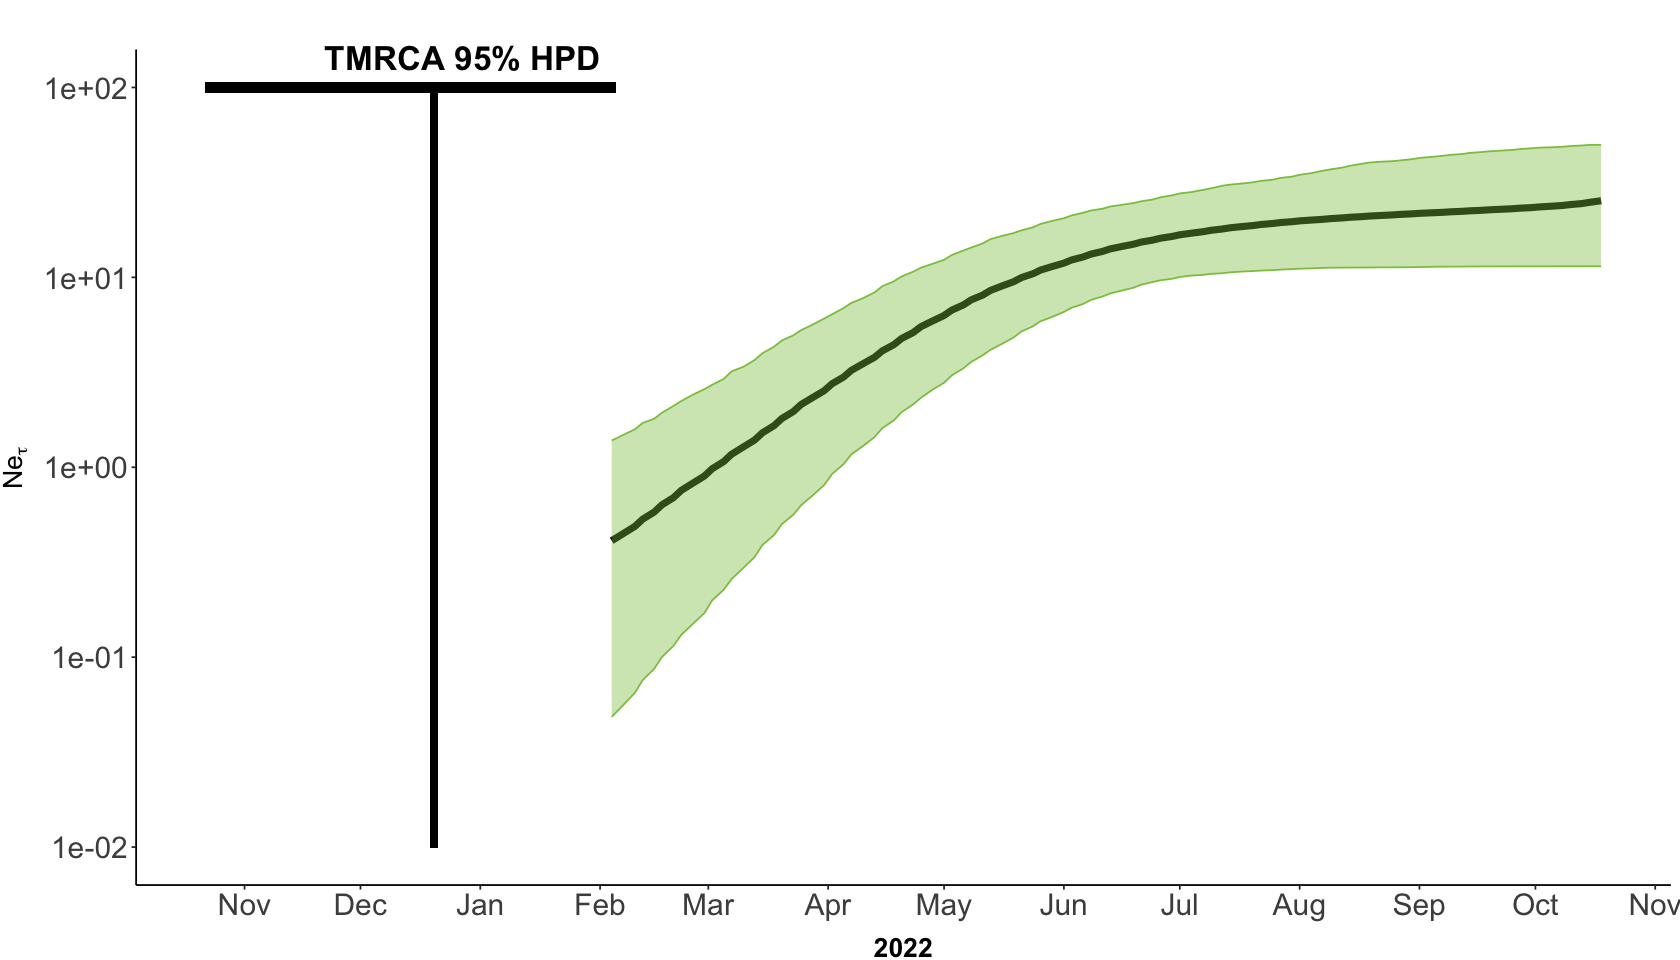

In [1529]:
plot_netau + geom_segment(aes(x = tmrca_lower, y = 100, yend=100, xend=tmrca_upper),
                          size=3) +
             geom_segment(aes(x=tmrca, xend=tmrca, y=100, yend=0.01),
                          size=2) +
             ggtitle(label = 'TMRCA 95% HPD') + theme(plot.title = element_text(size = 20, hjust=.15, vjust=-4)) +
             scale_y_continuous(trans='log10')
#ggsave('netau_tmrca.png', width=14, height=8)


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


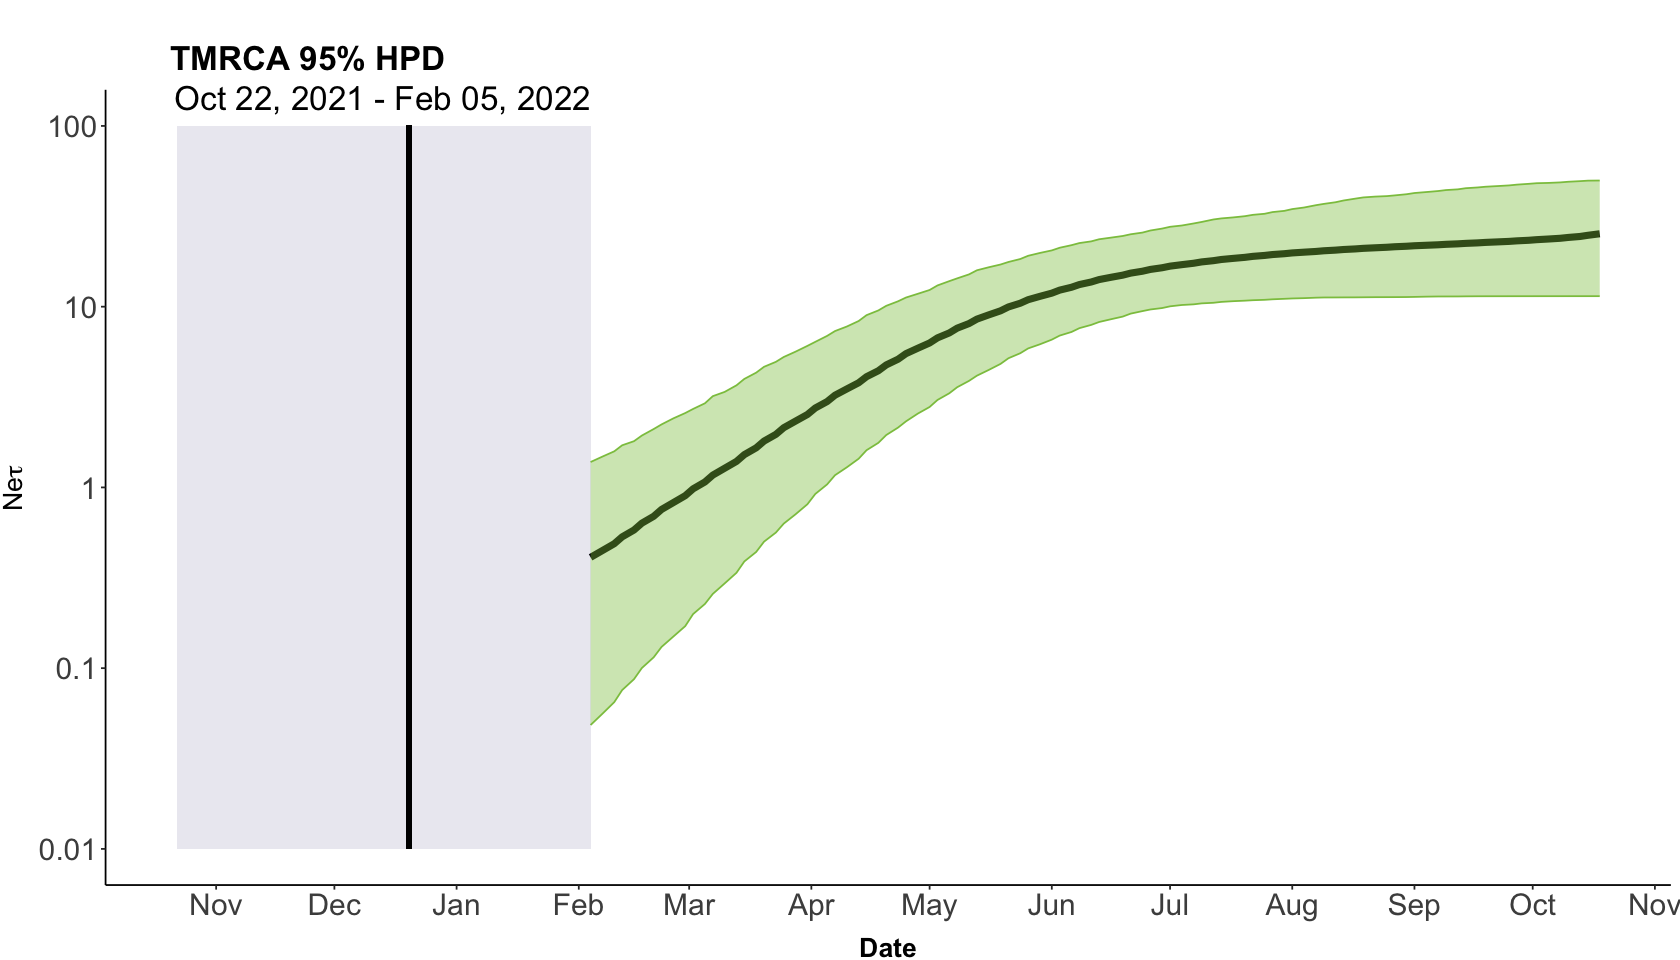

In [1532]:
plot_log_scale_netau + 
             annotate("rect", xmin=tmrca_lower, xmax=tmrca_upper-1, ymin=0.01, ymax=100, alpha=0.1, fill="midnightblue") +
             geom_segment(aes(x=tmrca, xend=tmrca, y=100, yend=0.01), size=1.5, color='black') +
             ggtitle(label = 'TMRCA 95% HPD', subtitle='Oct 22, 2021 - Feb 05, 2022') + theme(plot.title = element_text(size = 20, hjust=0.05, vjust=-4)) +
             scale_y_continuous(trans='log10', breaks=c(.01,0.1,1,10,100), label=c(.01,0.1,1,10,100)) + 
             theme(plot.subtitle = element_text(vjust=-4, hjust=0.06,size=20),
        axis.title.y = element_text(color="black", size=16, face="bold", vjust=2),
        axis.text=element_text(size=18))

#ggsave('netau_tmrca.png', width=14, height=8)

# Deriving Ne from logistic Netau

According to WHO, hmpxv1 incubation period is 5-21 days and duration of infection is 14-28 days.   
Estimate a late τ = 13 + 21 = 34 days 

### Read in Marlin's global case incidence (prevalence) estimates 
Model takes into account case counts, and case reporting delays, and viral incubation time. 


In [1228]:
rtpath <- '../case-rt-analysis/estimates/'

incidence <- read.table(paste0(rtpath,'case-incidence-estimates.tsv'), sep='\t', header=T)
prevalence <- read.table(paste0(rtpath,'case-prevalence-estimates.tsv'), sep='\t', header=T)


incidence <- incidence %>% filter(location=='World') %>% mutate(datetime = as_date(date))
prevalence <- prevalence %>% filter(location=='World') %>% mutate(datetime = as_date(date))

## Early case incidence estimates

Warning message:
“Removed 90 rows containing missing values (`geom_line()`).”


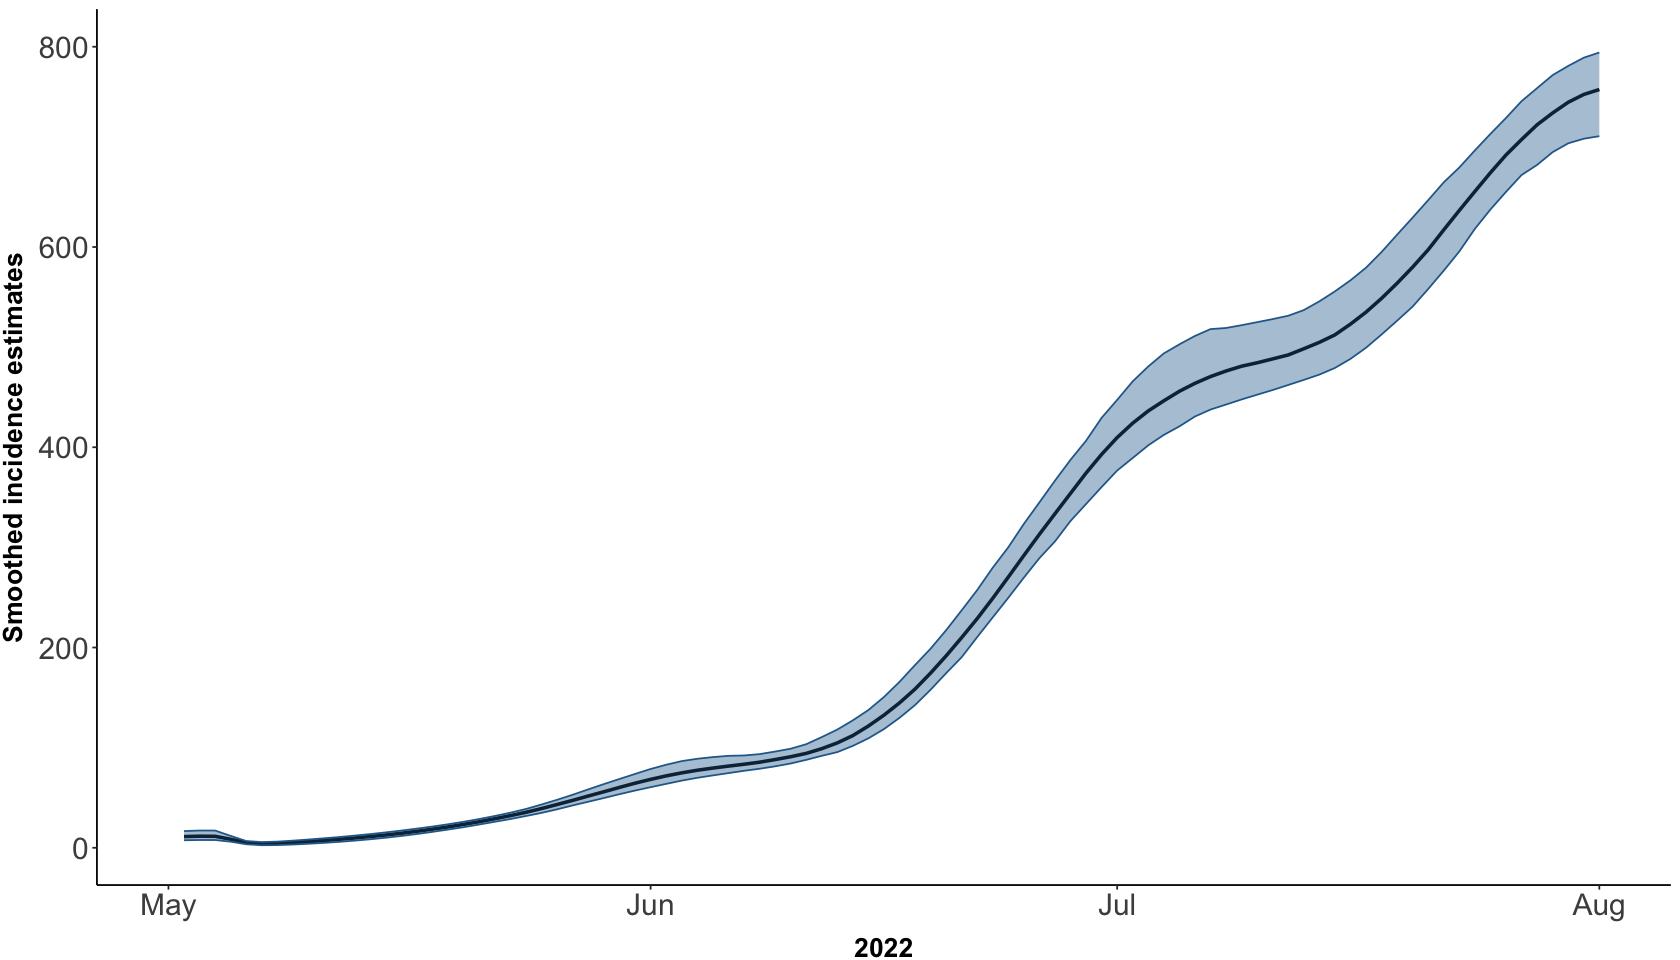

In [1273]:
plot_incidence <- incidence %>% ggplot(aes(x=datetime, y=median_I_smooth, group=1)) +
              geom_line(linewidth=1, color='black') +
              geom_ribbon(aes(ymin=I_smooth_lower_80, ymax=I_smooth_upper_80), 
                          color=rgb(0.15,0.41,0.6), 
                          alpha=0.4, 
                          fill=rgb(0.15,0.41,0.6)) +
              ylab('Smoothed incidence estimates') + xlab('2022') +
              scale_x_date(date_labels = "%b", date_breaks='months', limits=eod) + 
              my_theme()

plot_incidence

#ggsave("incidence.png", width=14, height=8)


## Overlaying prevlance estimates with Netau estimates

Warning message:
“Removed 90 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 90 rows containing missing values (`geom_line()`).”


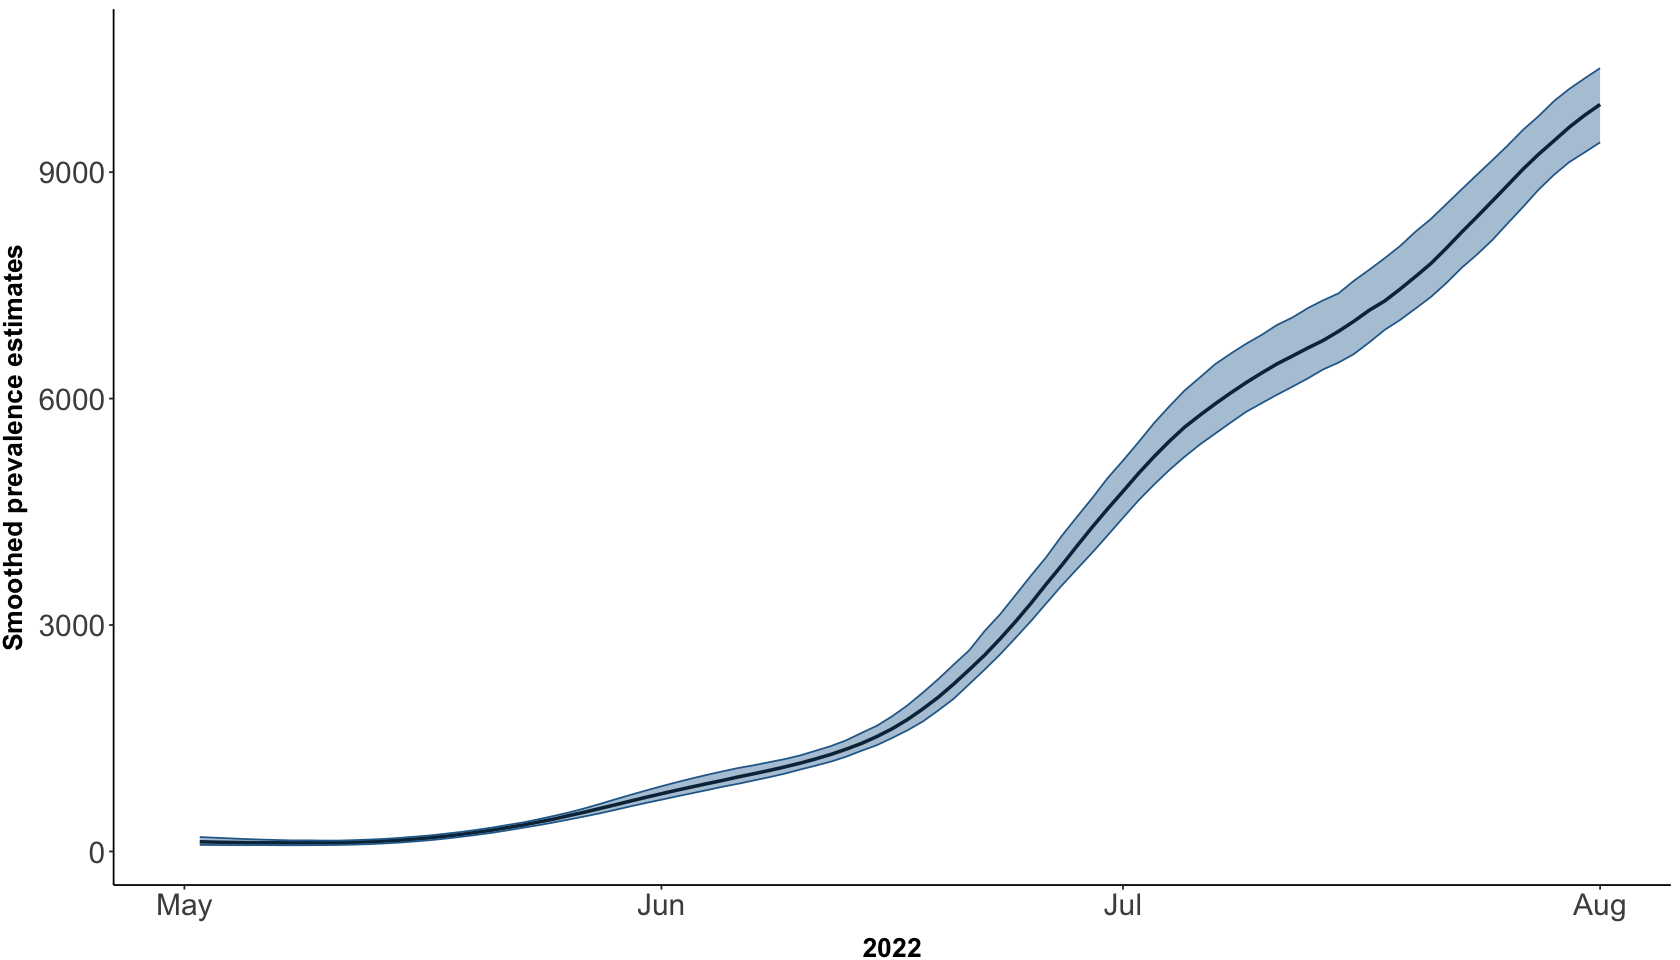

In [1252]:
plot_prevalence <- prevalence %>% ggplot(aes(x=datetime, y=median_prev, group=1)) +
              geom_line(linewidth=1, color='black') +
              geom_ribbon(aes(ymin=prev_lower_80, ymax=prev_upper_80), 
                          color=rgb(0.15,0.41,0.6), 
                          alpha=0.4, 
                          fill=rgb(0.15,0.41,0.6)) +
              ylab('Smoothed prevalence estimates') + xlab('2022') +
              scale_x_date(date_labels = "%b", date_breaks='months', limits=eod) + 
              my_theme()

plot_prevalence

#ggsave("prevalence.png", width=14, height=8)

Warning message:
“Removed 90 rows containing missing values (`geom_line()`).”


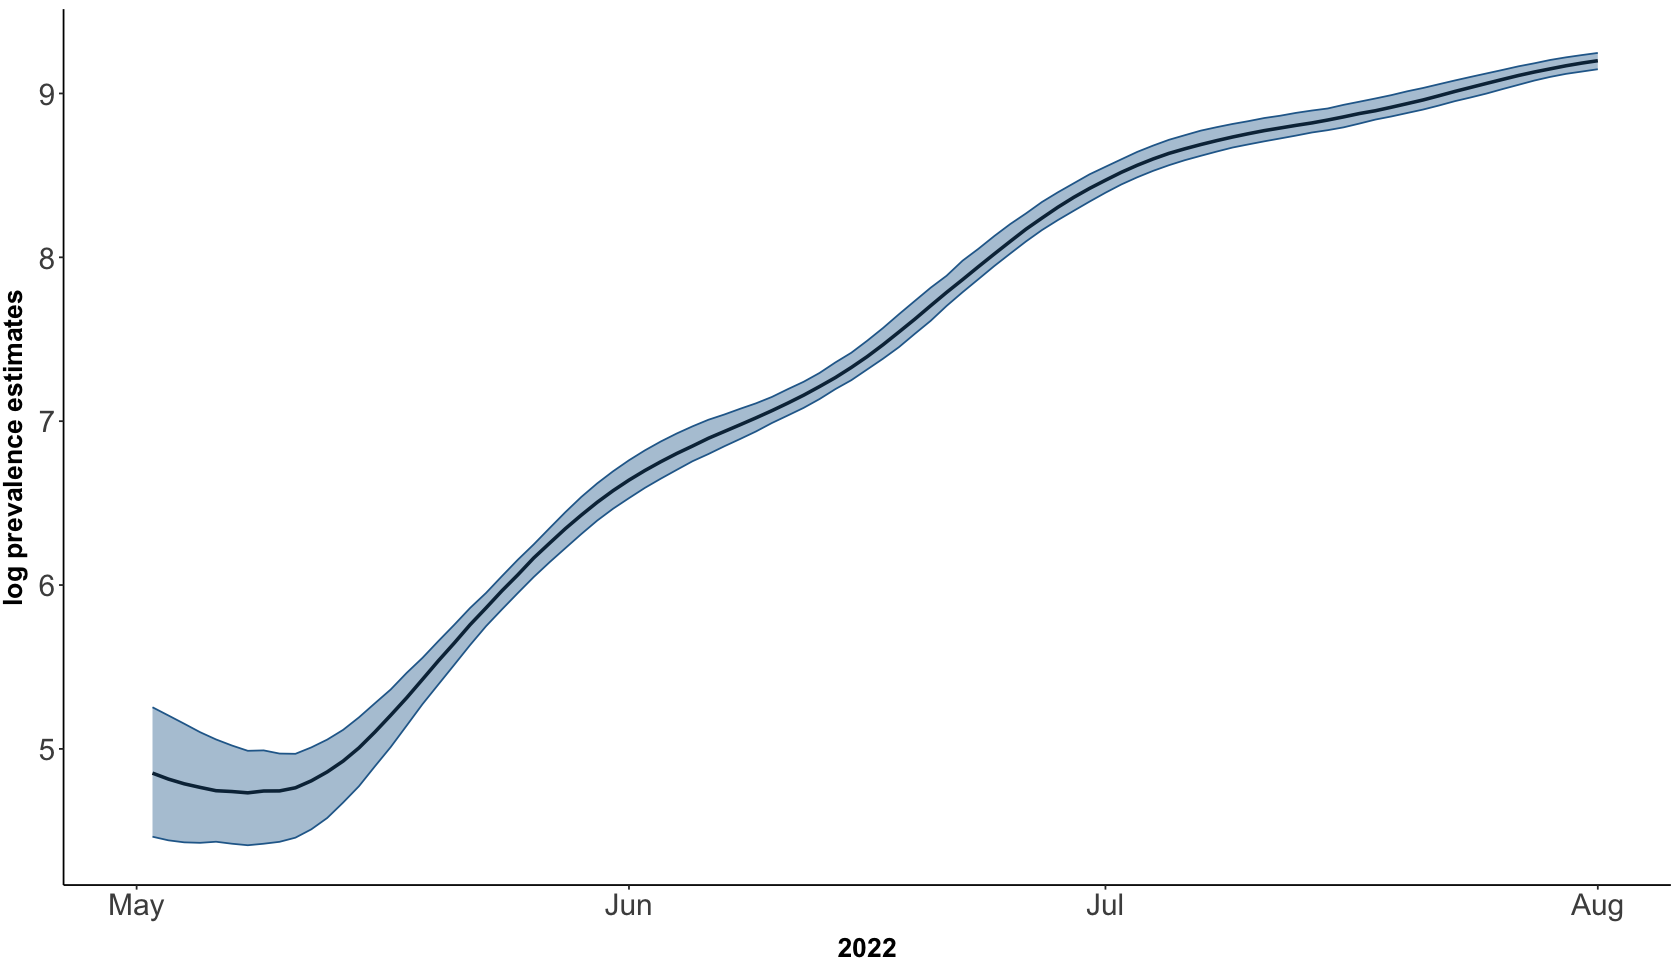

In [1238]:
log_prevalence <- prevalence %>% 
                      mutate(log_median=log(median_prev),
                             log_lower=log(prev_lower_80),
                             log_upper=log(prev_upper_80))

plot_log_prevalence <- log_prevalence %>% 
              ggplot(aes(x=datetime, y=log_median, group=1)) +
              geom_line(linewidth=1, color='black') +
              geom_ribbon(aes(ymin=log_lower, ymax=log_upper), 
                          color=rgb(0.15,0.41,0.6), 
                          alpha=0.4, 
                          fill=rgb(0.15,0.41,0.6)) +
              ylab('log prevalence estimates') + xlab('2022') +
              scale_x_date(date_labels = "%b", date_breaks='months', limits=eod) + 
              #scale_y_continuous(trans='log10') +
              my_theme()

plot_log_prevalence

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“Removed 63 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 90 rows containing missing values (`geom_line()`).”


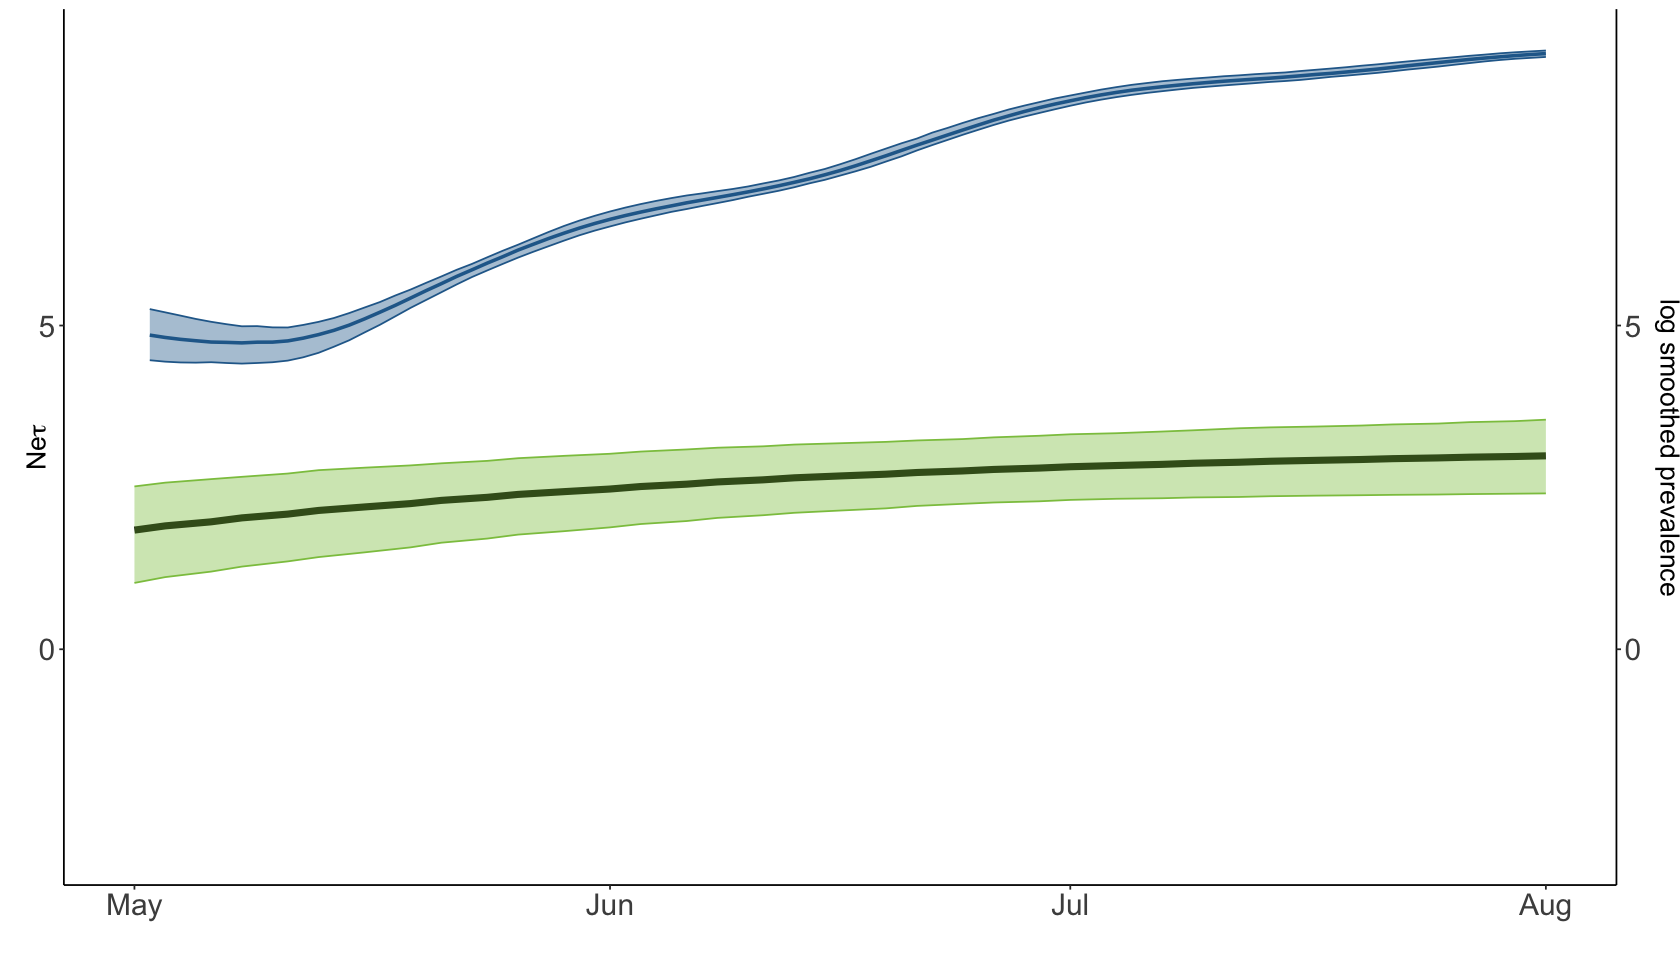

In [1535]:
log_prev <- log_prevalence %>% mutate(log_netau=log_median, ## duplicating names in order to plot different values
                                   log_netau_lower=log_lower,
                                   log_netau_upper=log_upper)

plot_netau_prev <- plot_log_netau + geom_line(data=log_prev, 
                             mapping=aes(x=datetime, y=log_median, group=1), 
                             linewidth=1,
                             color=rgb(0.15,0.41,0.6)) + 
                 geom_ribbon(data=log_prev, mapping=aes(ymin=log_lower, ymax=log_upper),                                     
                                    color=rgb(0.15,0.41,0.6), 
                                    alpha=0.4, 
                                    fill=rgb(0.15,0.41,0.6)) +
                 scale_y_continuous(sec.axis = sec_axis(trans=~., 
                                                        name="log smoothed prevalence")) +
                 scale_x_date(date_labels = "%b", date_breaks='months', limits=eod) +
                 theme(axis.title.y.right =  element_text(face='plain', vjust=2.5)) +xlab('') + ylab(bquote(Ne*tau))

plot_netau_prev


## (Rough) tau through time 

Pick a few points and fit logistic curve (e.g. on march 01, tau=13 ish days. on aug 01, tau=34 ish days).

,x,y,method,datetime,tauYears
,<date>,<dbl>,<chr>,<date>,<dbl>
1,2022-10-18,34,smooth(),2022-10-18,0.09315068
2,2022-10-15,34,smooth(),2022-10-15,0.09315068
3,2022-10-13,34,smooth(),2022-10-13,0.09315068
4,2022-10-10,34,smooth(),2022-10-10,0.09315068
5,2022-10-08,34,smooth(),2022-10-08,0.09315068
6,2022-10-05,34,smooth(),2022-10-05,0.09315068


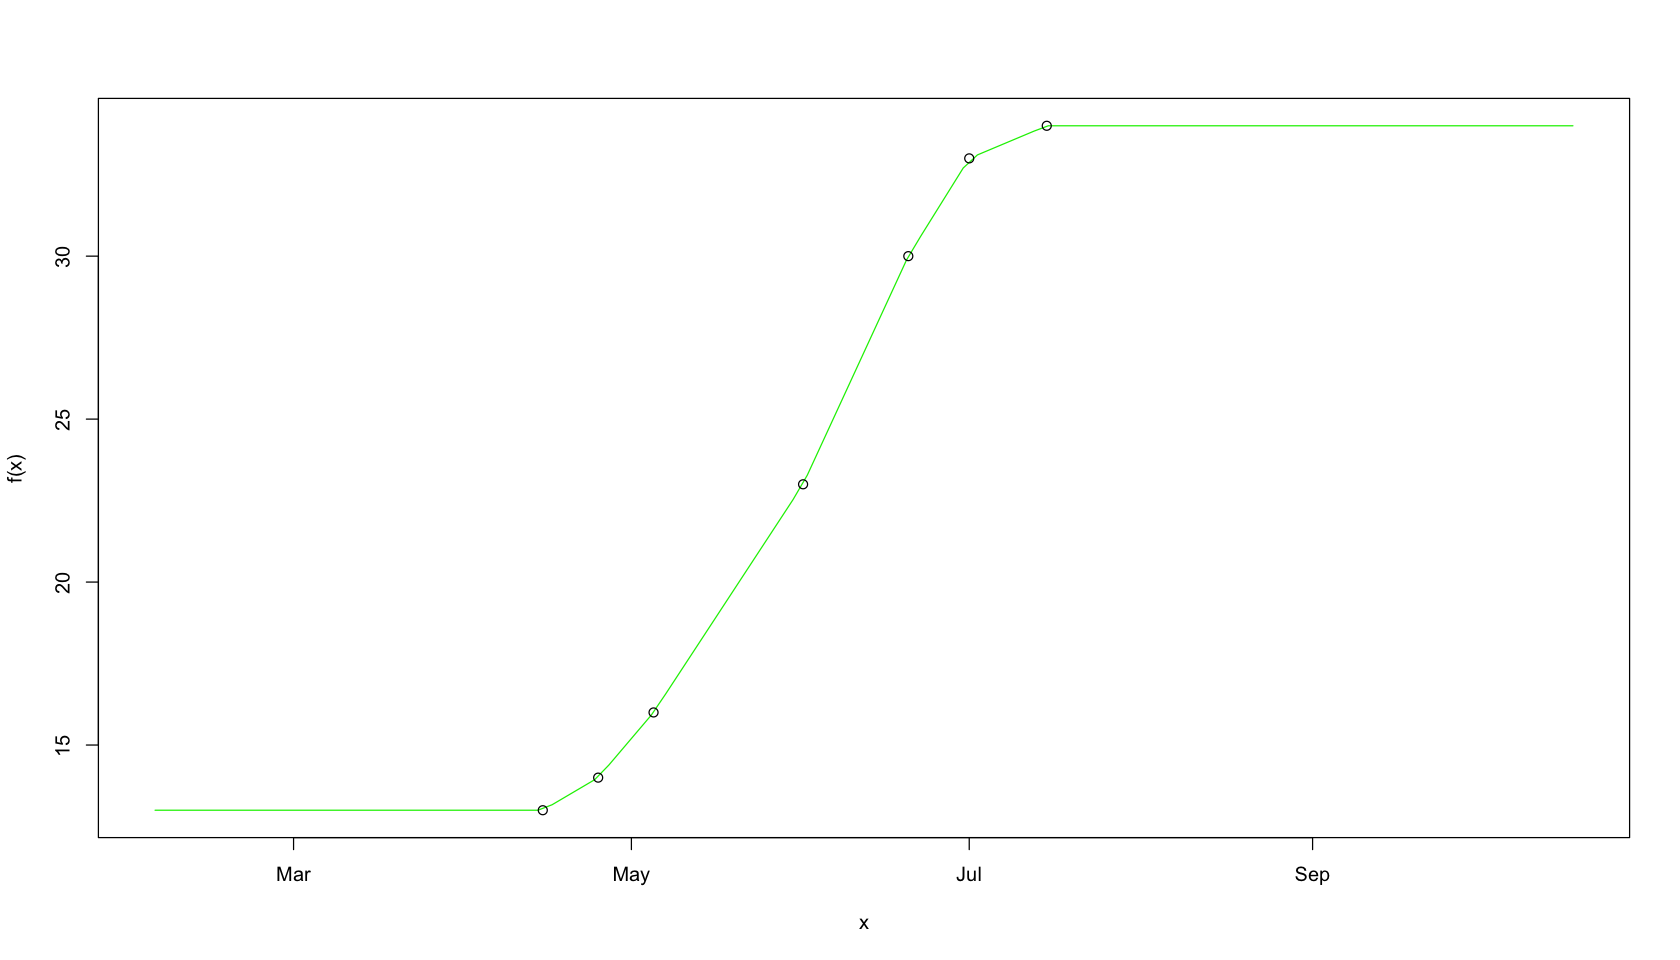

In [1095]:
dates <- data.frame(datetime=netau$datetime)

tmp <- data.frame(datetime = as.Date(c('2022-04-15',
                                        '2022-04-25',
                                        '2022-05-05',
                                        '2022-06-01',
                                        '2022-06-20',
                                        '2022-07-01',
                                        '2022-07-15')), 
                       tau = c(13, 
                               14, 
                               16, 
                               23, 
                               30, 
                               33,
                               34))

 splineData <- data.frame(
  with(tmp, 
       approx(datetime, tau, xout = dates$datetime, method = "linear", rule = 2)
  ),
  method = "smooth()"
)

f <- with(tmp, approxfun(datetime, tau, rule = 2))
curve(f(x), as.Date("2022-02-04"), as.Date("2022-10-18"), col = "green2")
with(tmp, points(datetime, tau))

splineData$datetime <- splineData$x
splineData$tauYears <- splineData$y / 365
head(splineData)

Warning message:
“Removed 41 rows containing missing values (`geom_line()`).”


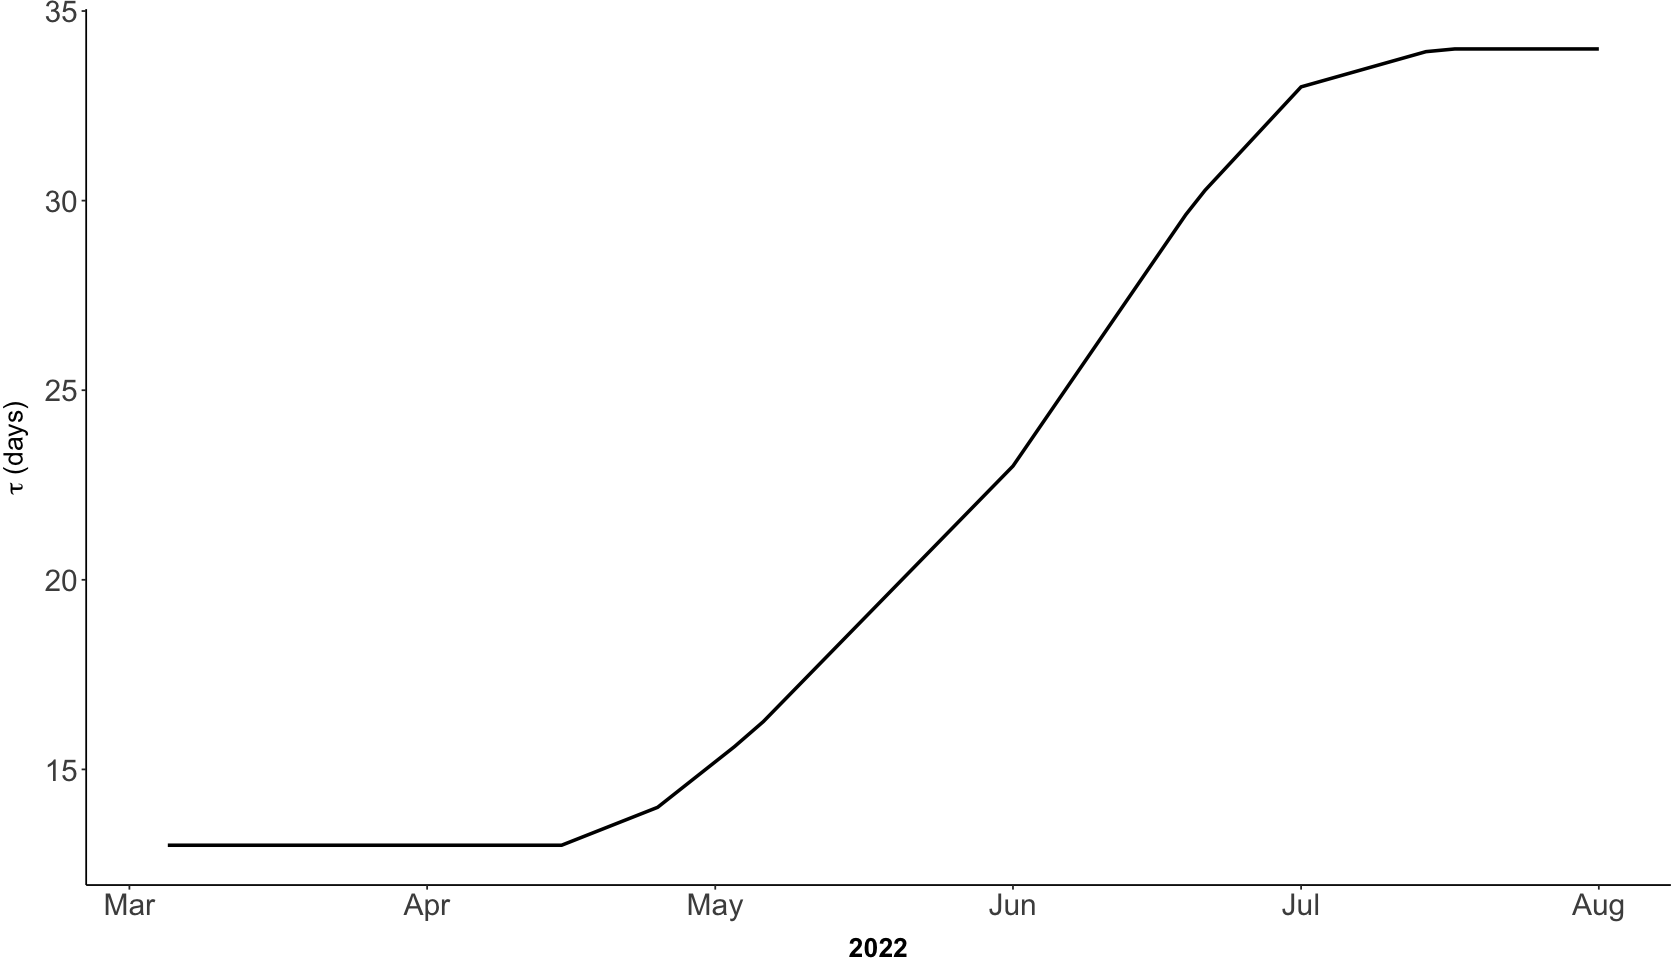

In [1129]:
plot_tau <- ggplot(splineData, aes(x,y)) + 
            geom_line(linewidth=1) +
            ylab(c(expression(paste(tau," (days)")))) + xlab('2022') +
            scale_x_date(date_labels = "%b", date_breaks='months',limits=as.Date(c('2022-03-04','2022-08-01'))) +
            my_theme()

plot_tau

### Estimate Ne from Netau 
divide Netau by taus to find ne 

Warning message:
“Removed 41 rows containing missing values (`geom_line()`).”


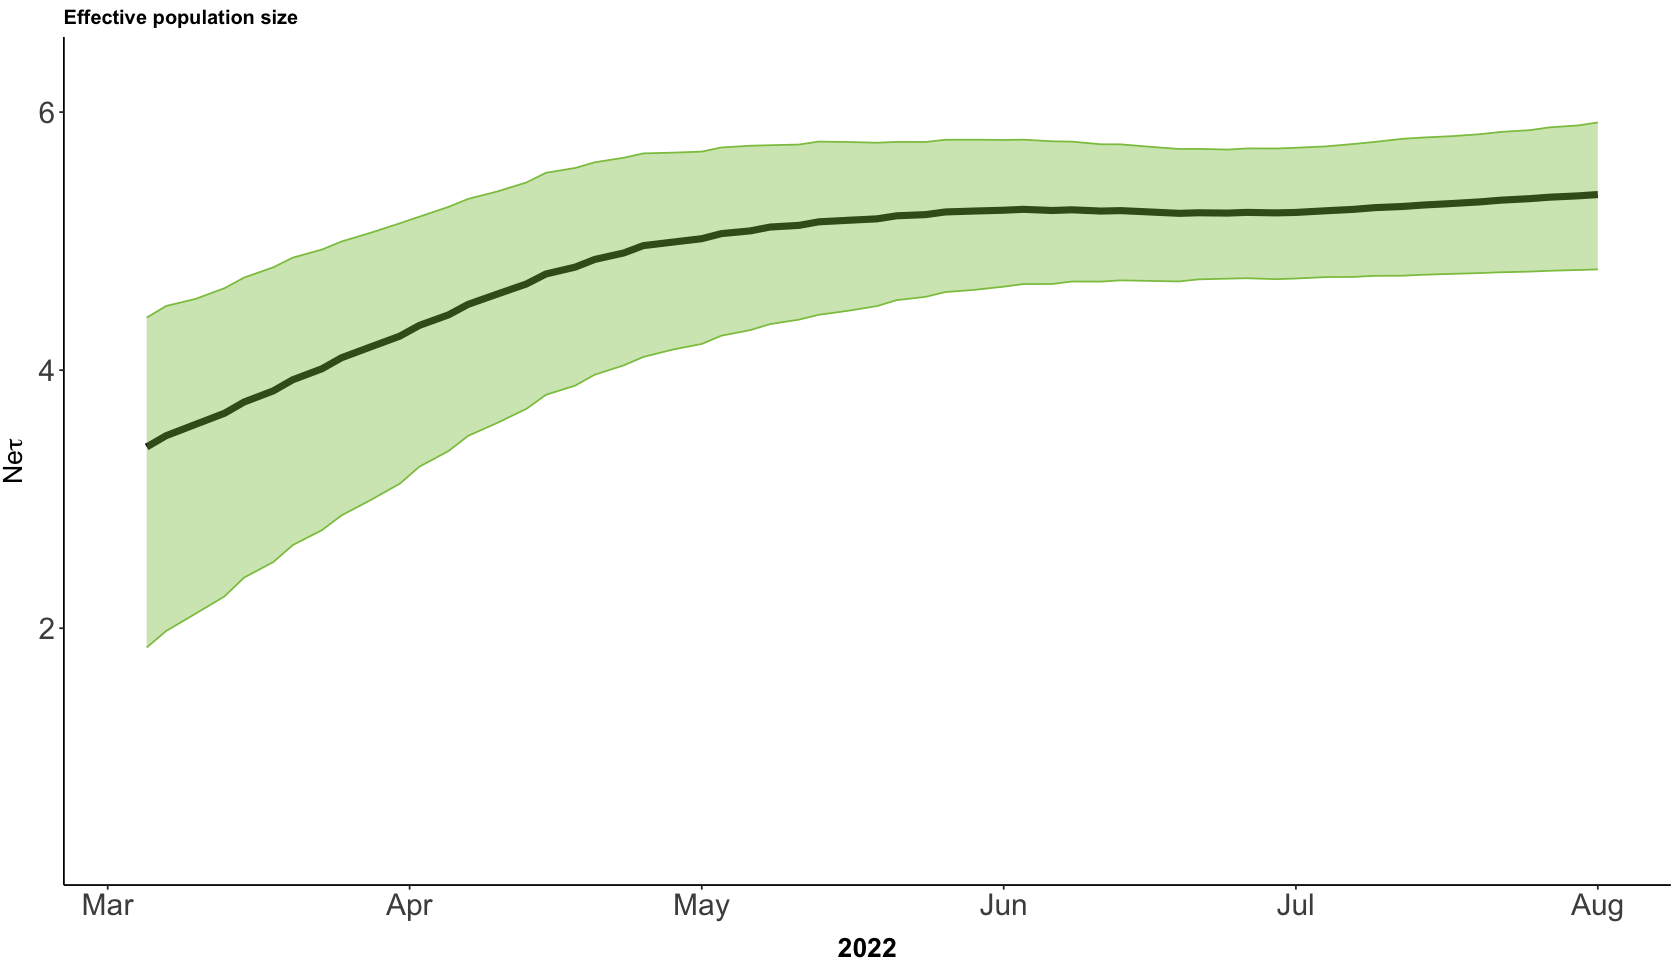

In [1533]:
ne_from_netau <- netau %>% left_join(splineData, by='datetime') %>% 
                 mutate(ne = mean/tauYears, 
                 ne_lower = lower/tauYears,
                 ne_upper = upper/tauYears)

plot_ne <- ggplot(ne_from_netau,aes(x=datetime, y=log(ne))) +
          geom_line(size=2, color='black') +
          geom_ribbon(aes(ymin=log(ne_lower), ymax=log(ne_upper)), color=rgb(0.55,0.77,0.3), alpha=0.4, fill=rgb(0.55,0.77,0.3)) +
          ylab(bquote(Ne*tau)) + xlab('2022') + ggtitle('Effective population size') + 
          scale_x_date(date_labels = "%b", date_breaks='months', limits=as.Date(c('2022-03-04','2022-08-01'))) + 
          my_theme()

plot_ne




### N/Ne through time

Warning message:
“Removed 30 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 30 rows containing missing values (`geom_line()`).”


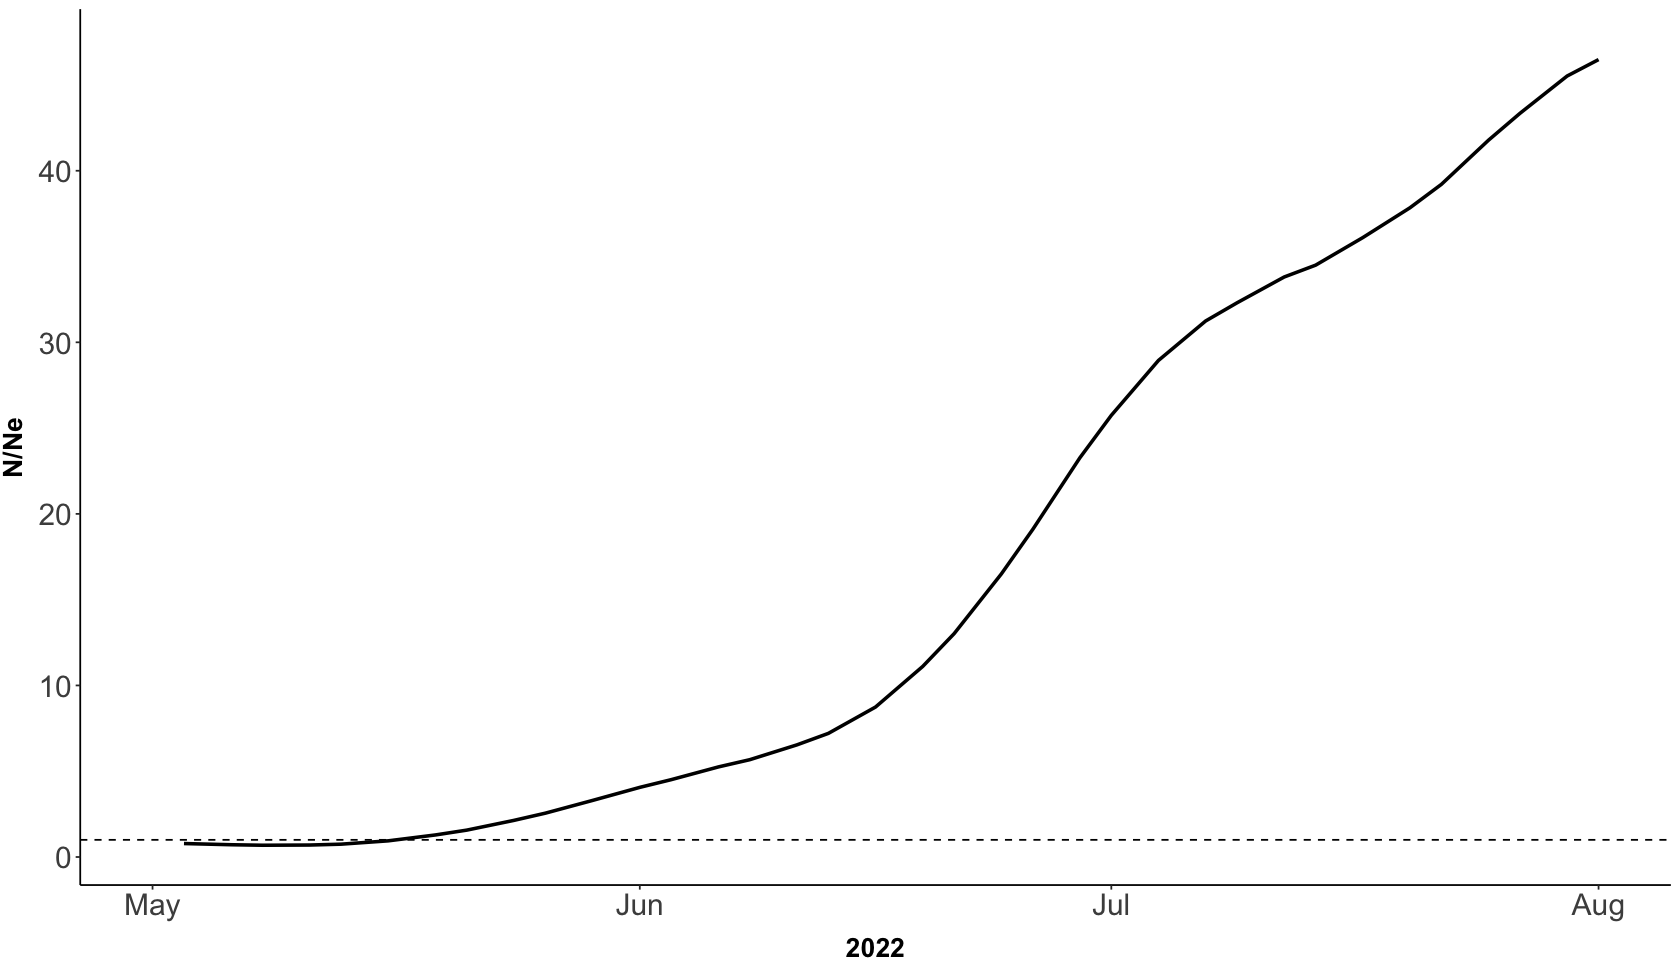

In [1507]:
ne_n_prev <- ne_from_netau %>% 
        left_join(prevalence, by='datetime') %>% 
        mutate(ratio = median_prev/ne) %>% 
        select(datetime, ne, median_prev, ratio) %>%
        na.omit

plot_ne_n_prev <- ggplot(ne_n_prev, aes(y=ratio, x=datetime)) + 
             geom_line(linewidth=1) + 
             xlab('2022') + ylab('N/Ne') +
             scale_y_continuous(breaks=pretty_breaks()) +
             scale_x_date(date_labels = "%b", date_breaks='months', limits=eod)+#as.Date(c('2022-03-04','2022-08-01'))) +
             my_theme() + geom_hline(yintercept=1, linetype=2)


plot_ne_n_prev 

#ggsave("ne_n_ratio.png", width=14, height=8)

## All together now

Warning message:
“Removed 63 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 90 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 63 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 30 rows containing missing values (`geom_line()`).”


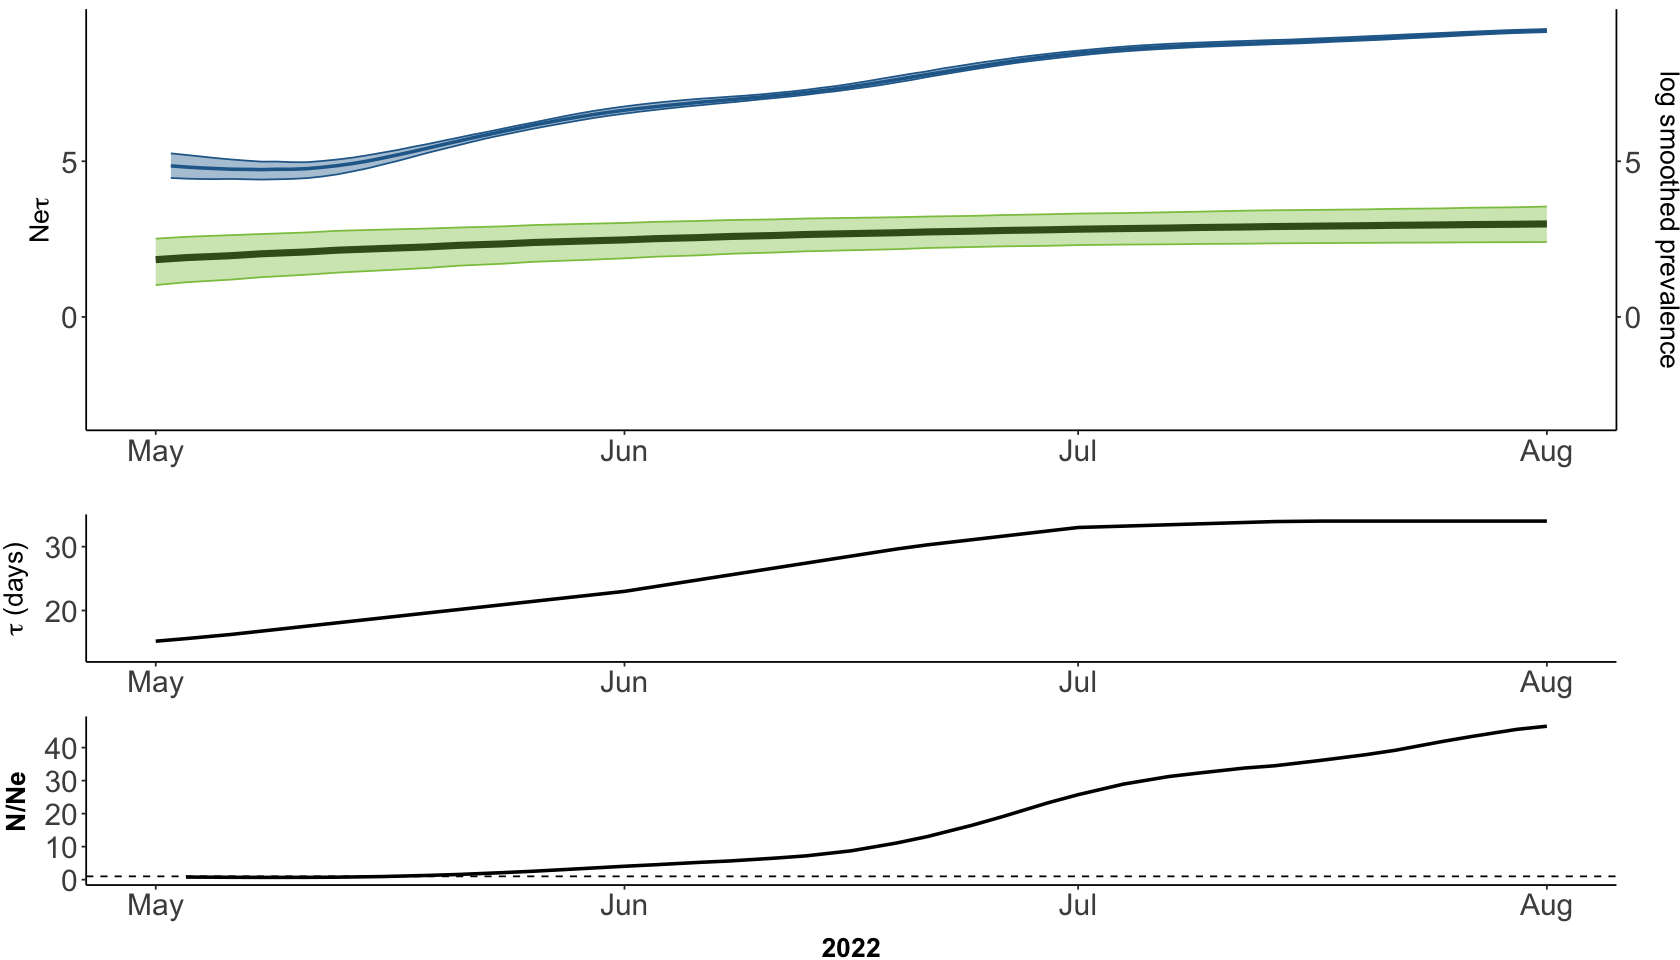

In [1536]:
plot_3 <- plot_grid(plot_netau_prev, plot_tau, plot_ne_n_prev, align='v', nrow=3, rel_heights=c(1,.4,.5) )

plot_3

#save_plot("n_ne.png", plot_3, nrow=3, ncol=1, base_width=14)



# epidemic growth rate r

In [1483]:
# import case count data 
cc_path <- '../case-rt-analysis/data/monkeypox-cases-counts.tsv'
cc <- read.table(cc_path, sep='\t', header=T)
cc <- cc %>% mutate(datetime = as_date(date)) %>% 
                    filter(location == 'World') %>%
                    mutate(log_cases = log(cases)) %>% 
                    mutate(log_cases = case_when(log_cases < 0 ~ 0,
                                           log_cases >=0 ~ log_cases))
tail(cc)

,location,date,cases,datetime,log_cases
,<chr>,<chr>,<dbl>,<date>,<dbl>
177,World,2022-10-25,137,2022-10-25,4.919981
178,World,2022-10-26,657,2022-10-26,6.487684
179,World,2022-10-27,102,2022-10-27,4.624973
180,World,2022-10-28,244,2022-10-28,5.497168
181,World,2022-10-29,143,2022-10-29,4.962845
182,World,2022-10-30,21,2022-10-30,3.044522


### linear regression on log transformed case counts
r = 0.0496 per day == 14.0 day doubling time

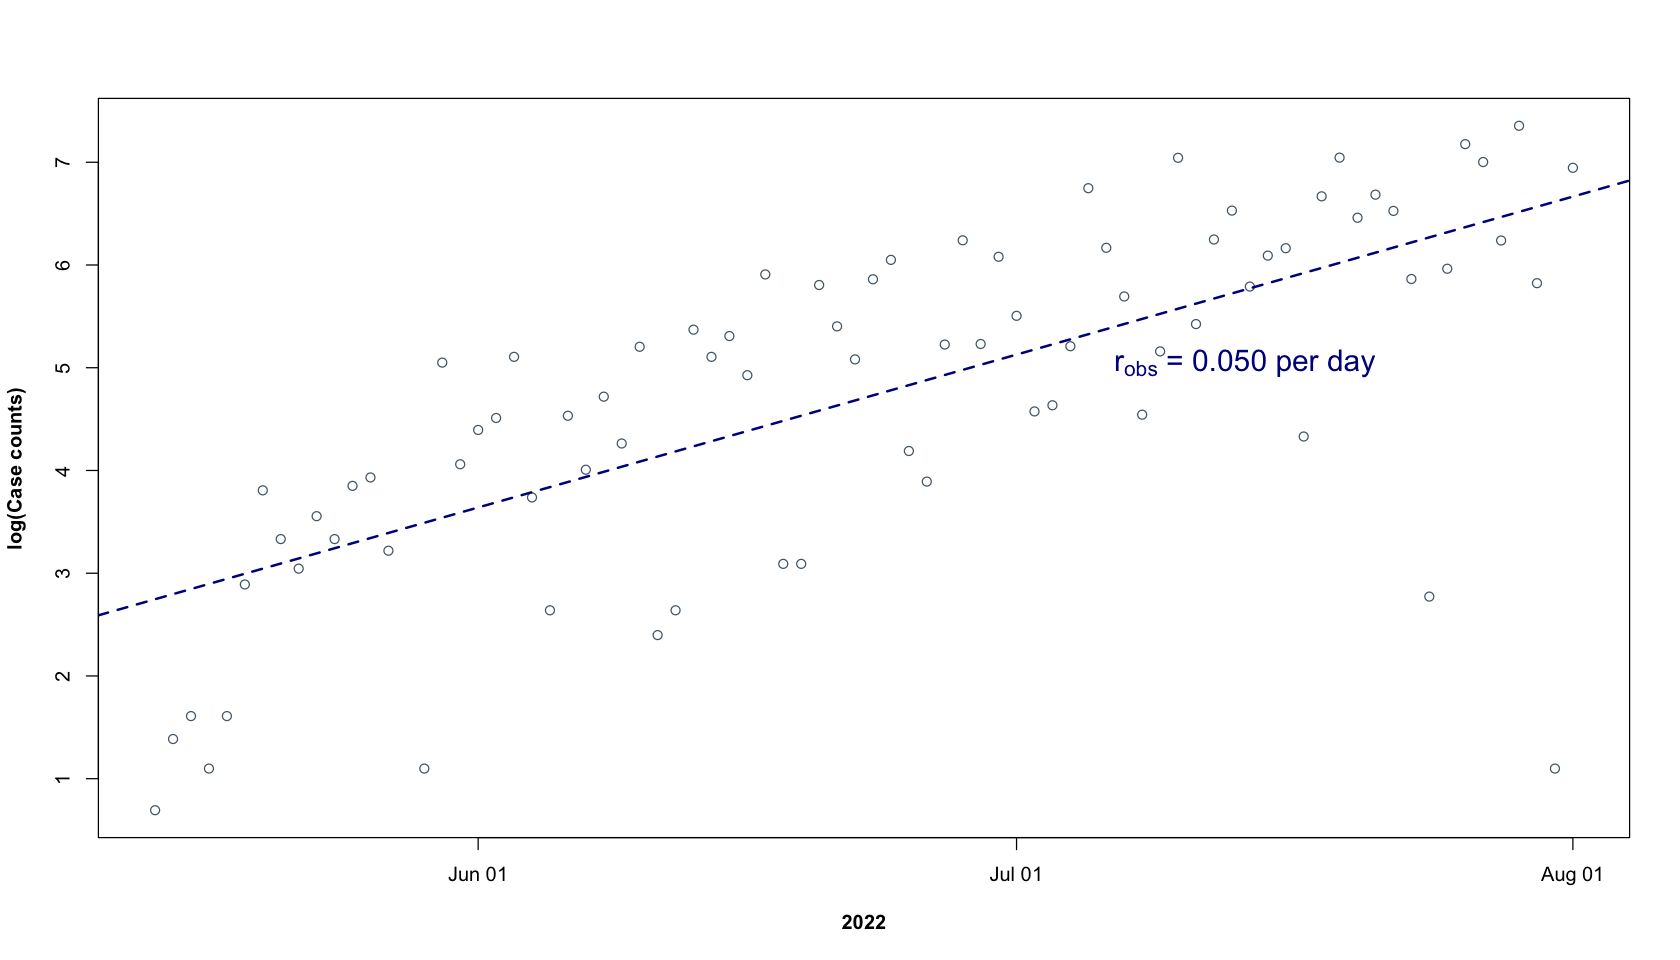

In [623]:
cc_early <- cc %>% 
            mutate(decimal = decimal_date(datetime)) %>%
            filter(decimal <= 2022.581) %>% # 2022-05-14 - 2022-08-01 
            filter(log_cases > 0)

lm.cc_early <- lm(log(cc_early$cases) ~ datetime, data=cc_early) 

#png("r_cases.png", width=500, height=350)
plot(y=cc_early$log_cases, 
     x=cc_early$datetime,
     #main="Global", 
     xlab='2022', 
     ylab='log(Case counts)',
     col='#536878',
     font.lab = 2)
title(expression(paste('r'[obs],' = 0.050 per day')), line = -11, adj=0.8, cex.main=1.25, col.main='darkblue', cex.main=1.5)

abline(lm.cc_early, col='darkblue', lty=2, lwd=2)
#dev.off()


### compare to logistic growth rate r <sub>est

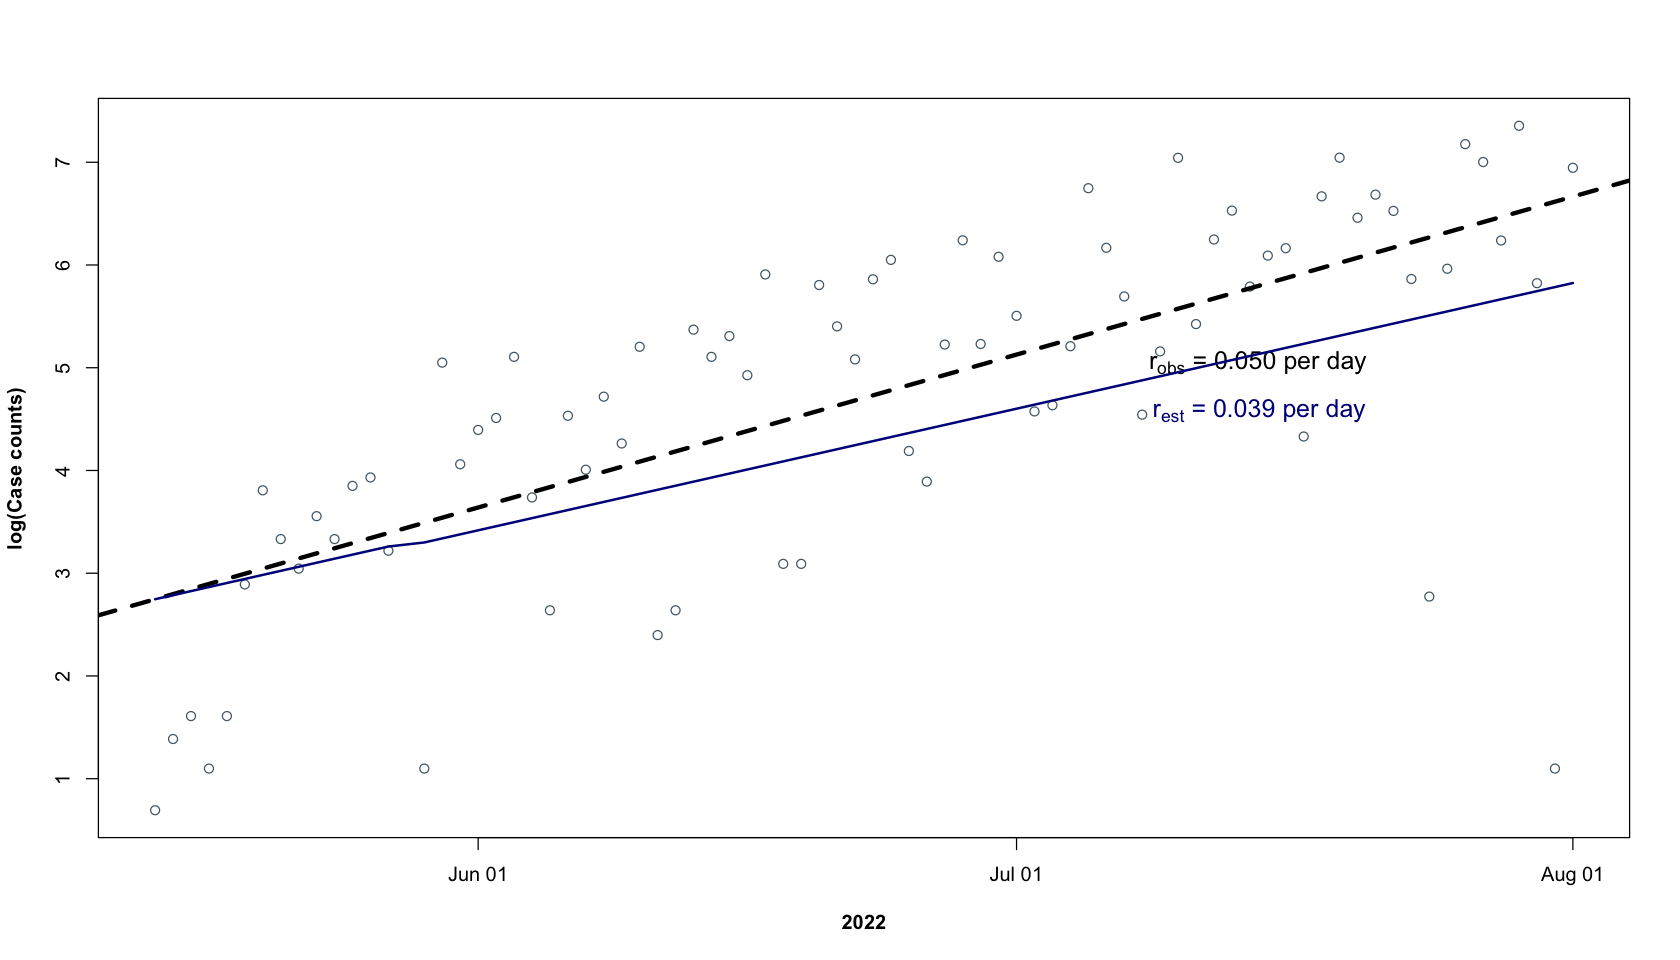

In [624]:
logistic_r <- 0.03945506849315068 #via BEAST 
r_overlay <- tibble(datetime=cc_early$datetime) %>% 
              mutate(x=0:(length(datetime)-1)) %>%
            # mutate(y=logistic_r) %>%
              mutate(z=lm.cc_early$fitted.values[1]) %>%
              mutate(infections=case_when(
                          x == 0 ~ z, 
                          x >= 1 ~ logistic_r*x + z))
#png('r_overlay.png', width=500, height=350)
plot(y=cc_early$log_cases, 
     x=cc_early$datetime,
     #main="Global", 
     xlab='2022', 
     ylab='log(Case counts)',
     col='#536878',
     font.lab = 2)
title(expression(paste('r'[obs],' = 0.050 per day')), line = -11, adj=0.8, cex.main=1.25)
title(expression(paste('r'[est],' = 0.039 per day')), line = -13, adj=0.8, cex.main=1.25, col.main='darkblue')
abline(lm.cc_early, lty=2, lwd=3.5)
lines(x=r_overlay$datetime, y=r_overlay$infections, lwd=2, col='darkblue')
#dev.off()


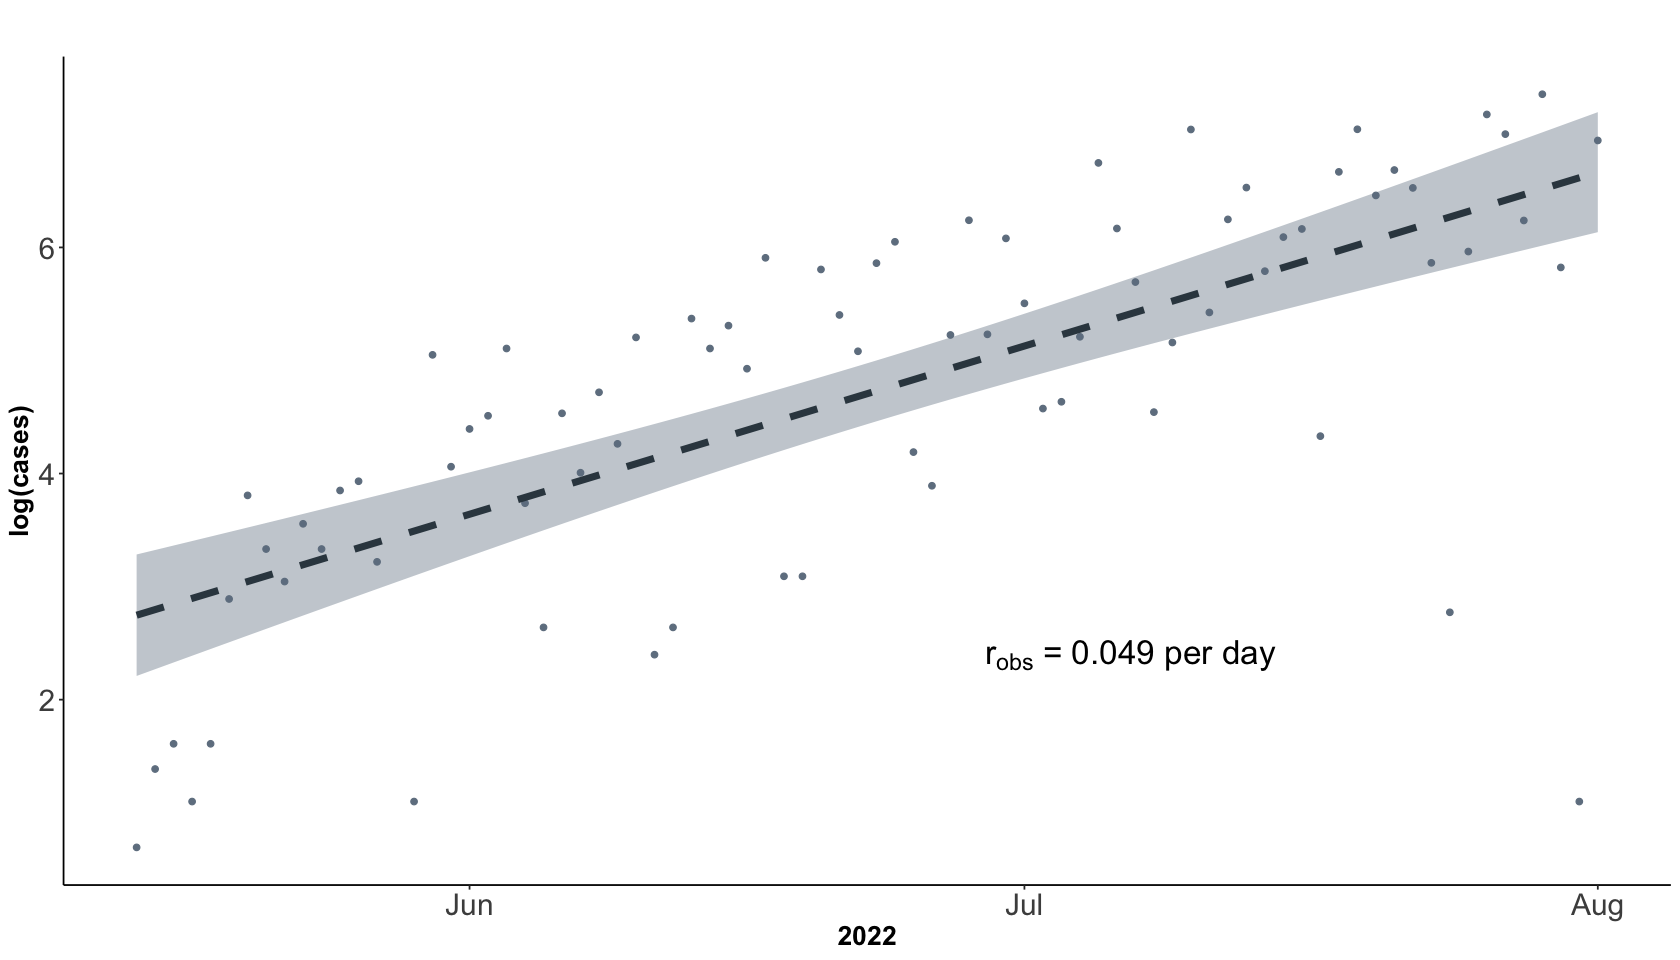

In [622]:
ggplot(cc_early, aes(x=datetime, y=log_cases)) + 
    geom_point(color='#708090') + 
    stat_smooth(method = "lm", #,se=False,
                formula = y ~ x, 
                fill='#708090', 
                color='#36454f',
                size=2,
                linetype = "dashed") + 
    ylab('log(cases)') + xlab('2022') + 
    ggtitle(label = expression(paste('r'[obs],' = 0.049 per day'))) + 
    theme(plot.title = element_text(size = 20, vjust = -85, hjust=.7),
          plot.subtitle = element_text(size = 20, color = "#a64d79", vjust = -88,hjust = .7),
          axis.text=element_text(size=18),
          axis.title=element_text(size=16,face="bold"),
          panel.grid.minor.x = element_line(),
          panel.border     = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          strip.background = element_rect(fill = "white", colour = "black", linewidth = rel(2)),
          axis.line = element_line(colour = "black", linewidth = rel(1)),
          legend.key = element_blank(),
          panel.background = element_rect(fill = "white", colour = NA)) 

#ggsave("r_cases_gg.png", width=14, height=8)

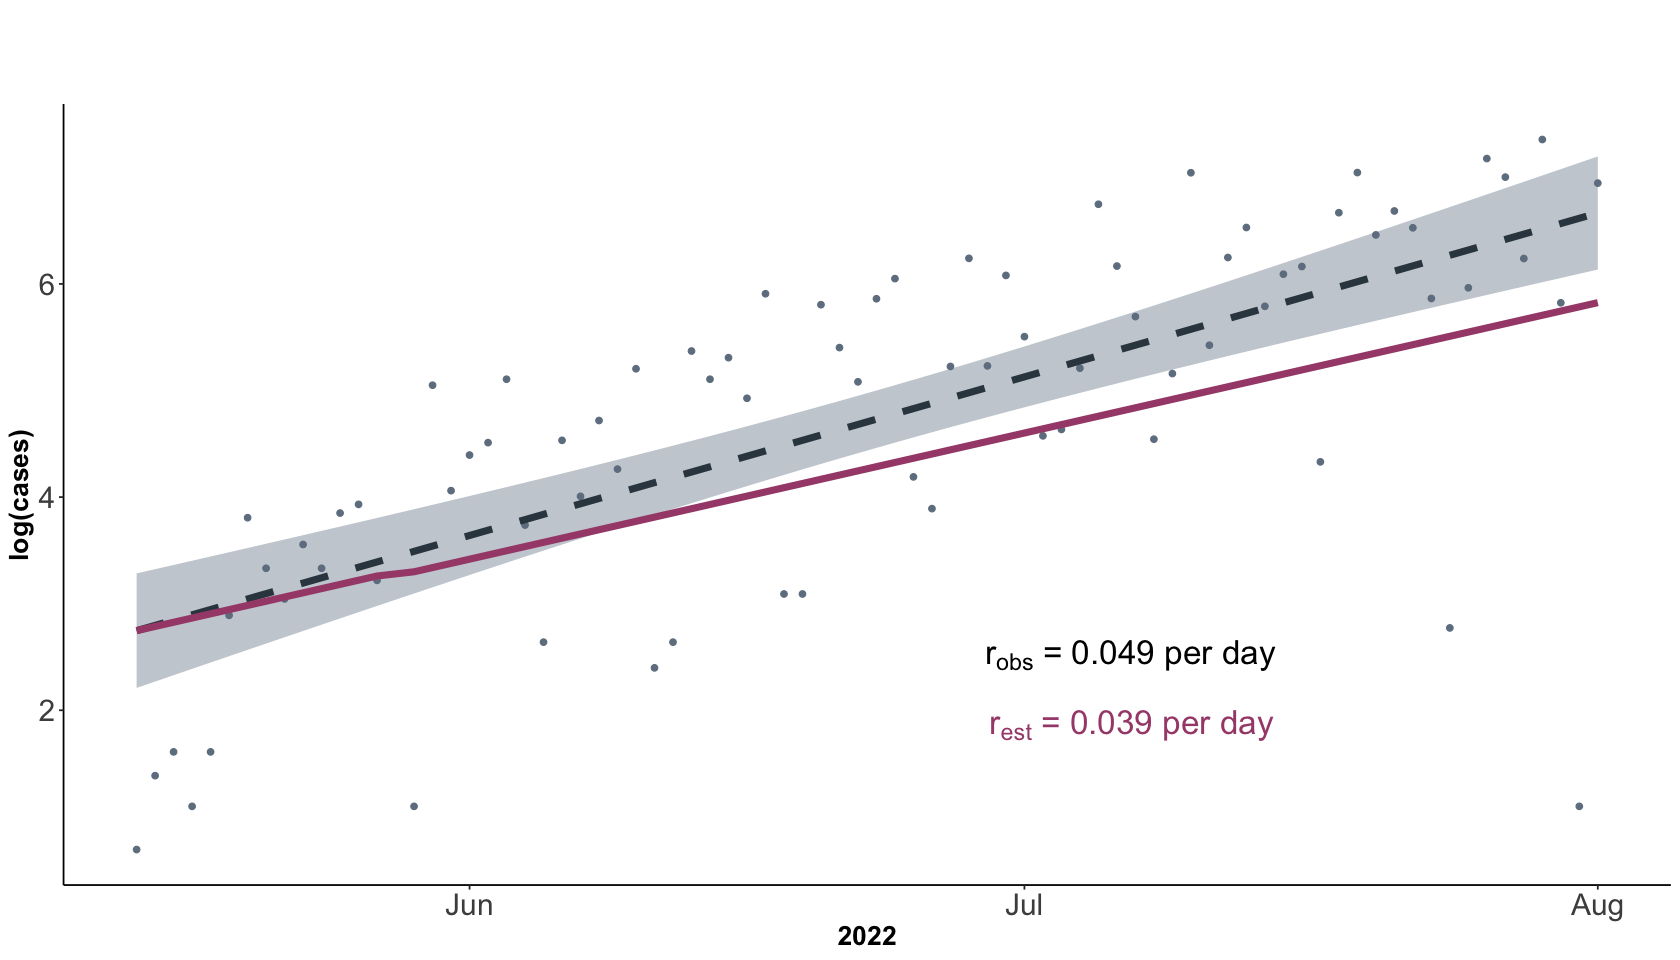

In [621]:
ggplot(cc_early, aes(x=datetime, y=log_cases)) + 
    geom_point(color='#708090') + 
    stat_smooth(method = "lm", #,se=False,
                formula = y ~ x, 
                fill='#708090', 
                color='#36454f',
                size=2,
                linetype = "dashed") + 
    ylab('log(cases)') + xlab('2022') + 
    ggtitle(subtitle=expression(paste('r'[est],' = 0.039 per day')), label = expression(paste('r'[obs],' = 0.049 per day'))) + 
    geom_line(data=r_overlay, mapping=aes(x=datetime, y=infections), size=2, color='#a64d79') +
    theme(plot.title = element_text(size = 20, vjust = -85, hjust=.7),
          plot.subtitle = element_text(size = 20, color = "#a64d79", vjust = -88,hjust = .7),
          axis.text=element_text(size=18),
          axis.title=element_text(size=16,face="bold"),
          panel.grid.minor.x = element_line(),
          panel.border     = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          strip.background = element_rect(fill = "white", colour = "black", linewidth = rel(2)),
          axis.line = element_line(colour = "black", linewidth = rel(1)),
          legend.key = element_blank(),
          panel.background = element_rect(fill = "white", colour = NA)) 

#ggsave("r_overlay_gg.png", width=14, height=8)



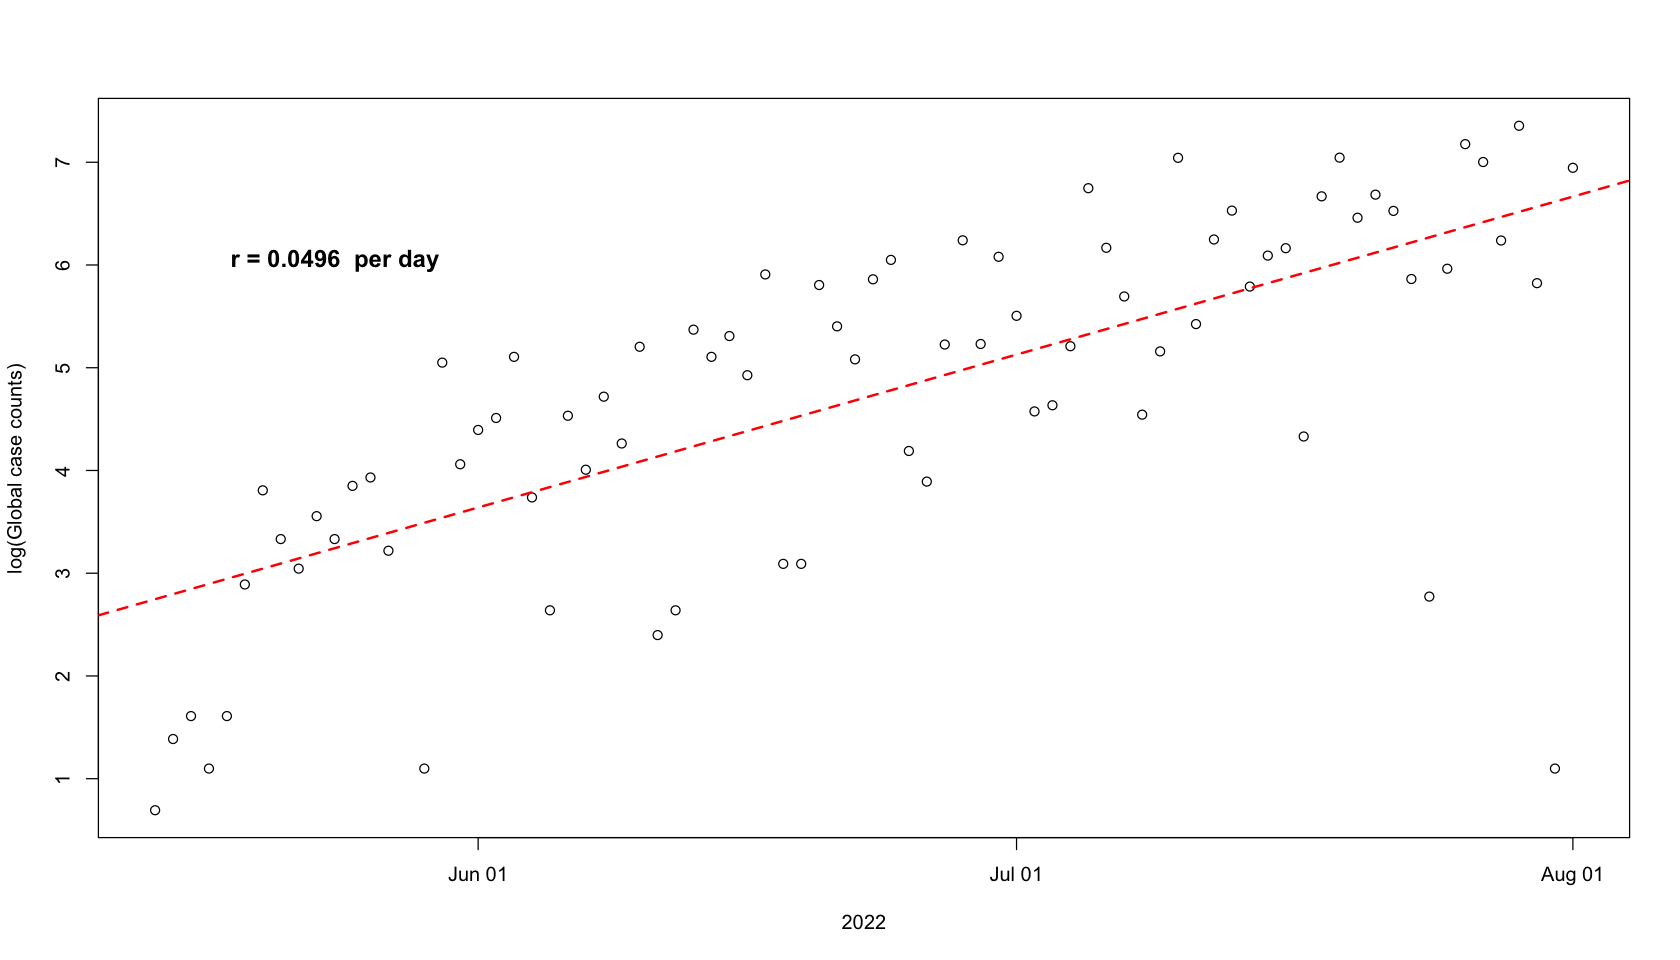

In [416]:
plot(y=cc_early$log_cases, 
     x=cc_early$datetime,
     xlab='2022', 
     ylab='log(Global case counts)')
title(paste("r =",round(lm.cc_early$coefficients[2],4)," per day"), line = -7, adj=0.1)

locator()

abline(lm.cc_early, col='red', lty=2, lwd=2)
abline()


Warning message:
“Removed 12 rows containing missing values (`geom_point()`).”


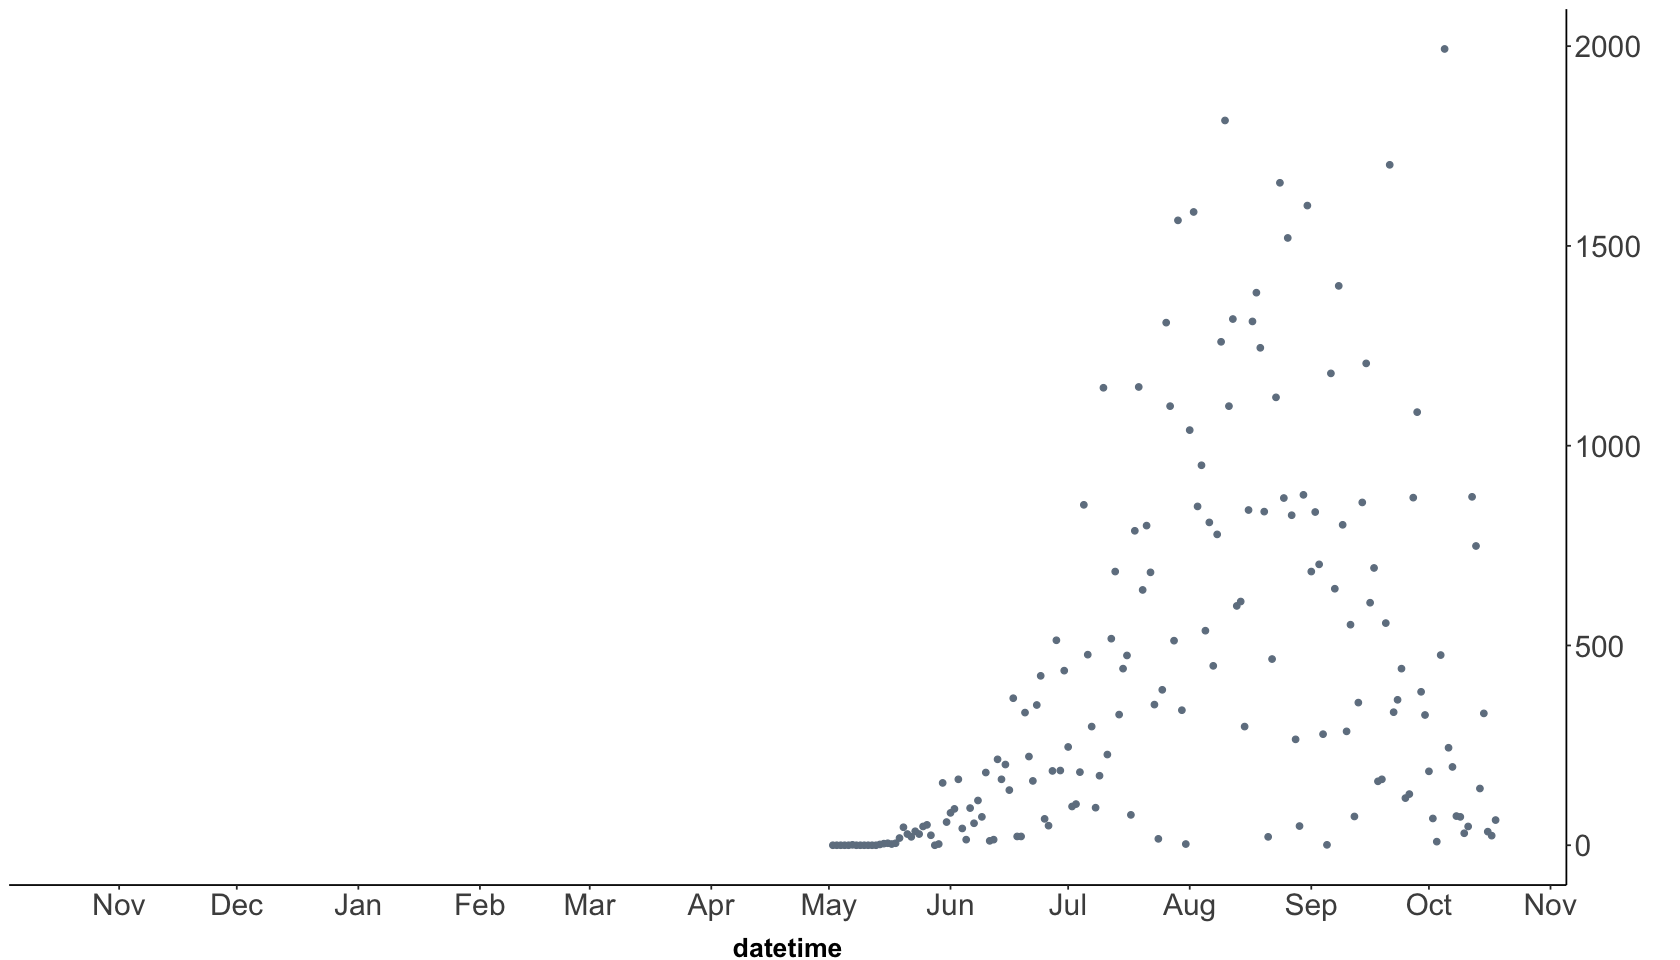

In [1501]:
ggplot(cc, aes(x=datetime, y=cases)) + 
    geom_point(color='#708090') + my_theme() +
    scale_x_date(date_labels = "%b", date_breaks='months', limits=as.Date(c('2021-10-22','2022-10-18'))) +
    scale_y_continuous(position = "right") + ylab('')

#ggsave('casecount_overlay.png',width=14, height=8)
